In [1]:
import pandas as pd
import json
import numpy as np
import os
from core.constants import RICKD_RUNNING_METADATA_CLEANED_FILE, RICKD_SOURCE_DATA_FOLDER, RICKD_PROCESSED_DATA_FOLDER

run_data_meta_cleaned = pd.read_csv(RICKD_RUNNING_METADATA_CLEANED_FILE)

In [2]:
def extract_session_data(session_id, json_data, target_df) -> None:
    dv_data = json_data['dv_r']

    left_data = dv_data['left']
    right_data = dv_data['right']

    for key in left_data.keys():
        left_col = f'l_{key.lower()}'
        right_col = f'r_{key.lower()}'

        target_df.loc[target_df['id'] == session_id, left_col] = left_data[key]
        target_df.loc[target_df['id'] == session_id, right_col] = right_data[key]


In [3]:
total_sessions = len(run_data_meta_cleaned)
session_data_full = run_data_meta_cleaned.copy()

session_lengths_rows = []
failed_sessions = []

for idx, session in run_data_meta_cleaned.iterrows():
    print(f"Processing row: {idx} / {total_sessions}")
    session_id = session['id']
    rel_path = session['session_file_path']
    session_file = os.path.join(RICKD_SOURCE_DATA_FOLDER, str(rel_path))

    try:
        with open(session_file) as f:
            data = json.load(f)
            extract_session_data(session_id, data, session_data_full)

            running_data = data['running']
            hz = data['hz_r']

            for key_point in running_data.keys():
                session_lengths_rows.append({
                    'session_id': session_id,
                    'key_point': key_point,
                    'frames': len(running_data[key_point]),
                    'hz': hz
                })
    except FileNotFoundError:
        failed_sessions.append(session_id)

session_lengths_df = pd.DataFrame(session_lengths_rows)

Processing row: 0 / 1832
Processing row: 1 / 1832


/var/folders/2w/vl1bz9zs2c37dzy7d38b9cbm0000gn/T/ipykernel_44132/1431573766.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  target_df.loc[target_df['id'] == session_id, right_col] = right_data[key]
/var/folders/2w/vl1bz9zs2c37dzy7d38b9cbm0000gn/T/ipykernel_44132/1431573766.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  target_df.loc[target_df['id'] == session_id, left_col] = left_data[key]
/var/folders/2w/vl1bz9zs2c37dzy7d38b9cbm0000gn/T/ipykernel_44132/1431573766.py:12: PerformanceWarning: DataFrame is highly fragmen

Processing row: 2 / 1832
Processing row: 3 / 1832
Processing row: 4 / 1832
Processing row: 5 / 1832
Processing row: 6 / 1832
Processing row: 7 / 1832
Processing row: 8 / 1832
Processing row: 9 / 1832
Processing row: 10 / 1832
Processing row: 11 / 1832
Processing row: 12 / 1832
Processing row: 13 / 1832
Processing row: 14 / 1832
Processing row: 15 / 1832
Processing row: 16 / 1832
Processing row: 17 / 1832
Processing row: 18 / 1832
Processing row: 19 / 1832
Processing row: 20 / 1832
Processing row: 21 / 1832
Processing row: 22 / 1832
Processing row: 23 / 1832
Processing row: 24 / 1832
Processing row: 25 / 1832
Processing row: 26 / 1832
Processing row: 27 / 1832
Processing row: 28 / 1832
Processing row: 29 / 1832
Processing row: 30 / 1832
Processing row: 31 / 1832
Processing row: 32 / 1832
Processing row: 33 / 1832
Processing row: 34 / 1832
Processing row: 35 / 1832
Processing row: 36 / 1832
Processing row: 37 / 1832
Processing row: 38 / 1832
Processing row: 39 / 1832
Processing row: 40 /

In [5]:
from core.constants import RICKD_SESSION_DATA_FULL_FILE
session_data_full.to_csv(RICKD_SESSION_DATA_FULL_FILE, index=False)

In [6]:
failed_sessions_df = pd.DataFrame(failed_sessions, columns=['session_id'])
failed_sessions_df.to_csv(os.path.join(RICKD_PROCESSED_DATA_FOLDER, 'missing_session_files.csv'), index=False)

print("Number of missing session files:", len(failed_sessions))
failed_sessions_df

Number of missing session files: 0


,session_id


In [15]:
session_lengths_df['duration_seconds'] = session_lengths_df['frames'] / session_lengths_df['hz']
session_lengths_df.to_csv(os.path.join(RICKD_PROCESSED_DATA_FOLDER, 'session_lengths.csv'), index=False)

In [9]:
session_lengths_df.hz.value_counts()

hz
200    52884
120      300
Name: count, dtype: int64

In [12]:
# Do all sessions have the same frame count?
frame_counts_by_session = session_lengths_df.groupby('session_id')['frames'].nunique()
inconsistent_sessions = frame_counts_by_session[frame_counts_by_session > 1]

print("Number of sessions with inconsistent frame counts:", len(inconsistent_sessions))

Number of sessions with inconsistent frame counts: 0


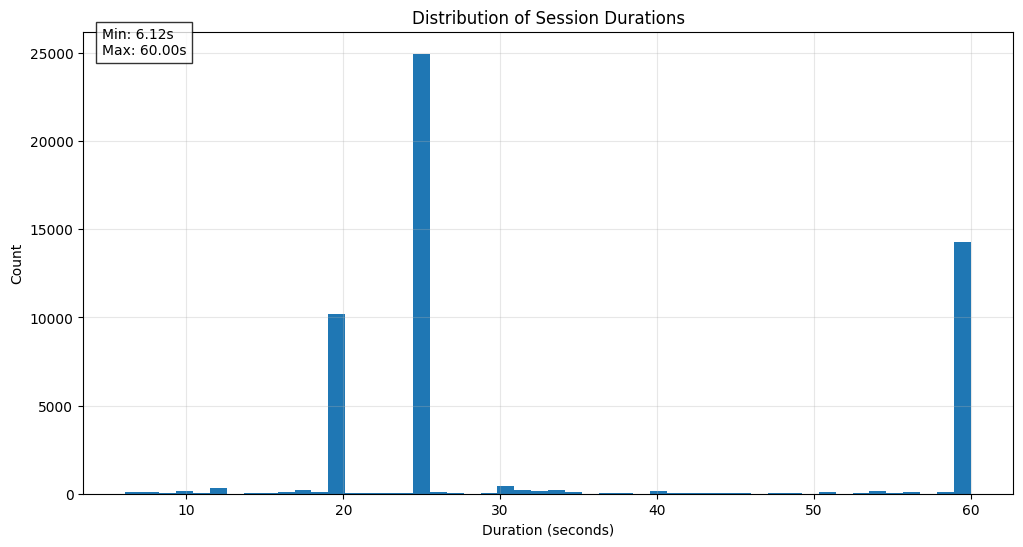

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(session_lengths_df['duration_seconds'], bins=50)
plt.title('Distribution of Session Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

min_duration = session_lengths_df['duration_seconds'].min()
max_duration = session_lengths_df['duration_seconds'].max()
plt.text(0.02, 0.95, f'Min: {min_duration:.2f}s\nMax: {max_duration:.2f}s',
            transform=plt.gca().transAxes,
            bbox=dict(facecolor='white', alpha=0.8)
        )

plt.show()


